# Notebook for match final results predictions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle as pk

#pd.set_option('display.max_rows', )
pd.set_option('display.max_columns', 200)

In [21]:
bm = 'PS'
H = bm + 'H'
D = bm + 'D'
A = bm + 'A'

k = 50.0

def get_best(s):

    h = s.FTHG
    a = s.FTAG

    BH = s[H + '_P']
    BD = s[D + '_P']
    BA = s[A + '_P']

    if max(BH, BD, BA) <= k:
        return None

    if BH == max(BH, BD, BA, k) and h > a or \
       BD == max(BH, BD, BA, k) and h == a or \
       BA == max(BH, BD, BA, k) and h < a :
        
        return 1
    
    return 0

In [22]:
filename_1 = "Serie-A-2122.csv"
filename_2 = "Serie-A-2223.csv"
filename_3 = "Premier-league-2122.csv"
filename_4 = "Premier-league-2223.csv"
filename_5 = "Bundesliga-2122.csv"
filename_6 = "Bundesliga-2223.csv"
filename_7 = "Liga-2122.csv"
filename_8 = "Liga-2223.csv"
filename_9  = "Ligue1-2122.csv"
filename_10 = "Ligue1-2223.csv"
filename_11 = "Super-lig-2122.csv"
filename_12 = "Super-lig-2223.csv"
filename_13 = "Eredivise-2122.csv"
filename_14 = "Eredivise-2223.csv"
filename_15 = "Liga-1-2122.csv"
filename_16 = "Liga-1-2223.csv"
filename_17 = "Serie-A-2021.csv"

In [23]:
#Loading the datasets

filenames = [filename_1, filename_2, #filename_3, filename_4,
             #filename_5, filename_6, filename_7,
             #filename_8, filename_9, filename_10,
             #filename_11, filename_12, filename_13,
             #filename_14, filename_15, filename_16,
             filename_17]

tmp_features = ['HomeTeam','AwayTeam','FTHG','FTAG', H, D, A]

df = pd.DataFrame()
for name in filenames:
    tmp = pd.read_csv(name, sep=',')
    df = pd.concat([df, tmp[tmp_features]])
df.shape

(1100, 7)

Create the result_index

In [24]:
df[H + '_P'] = round(100/(1 + df[H]*(1/df[D] + 1/df[A])), 2)
df[A + '_P'] = round(100/(1 + df[A]*(1/df[H] + 1/df[D])), 2)
df[D + '_P'] = round(100/(1 + df[D]*(1/df[H] + 1/df[A])), 2)

features = [H, D, A]
target   = [bm + '_income_index']

df[bm + '_income_index'] = df.apply(get_best, axis=1)
df[bm + '_income_index'].value_counts()

PS_income_index
1.0    399
0.0    213
Name: count, dtype: int64

In [25]:
df[df[bm + '_income_index'] == 1][[bm + 'H', bm + 'D', bm + 'A']].apply(lambda x: min(x[bm + 'H'], x[bm + 'D'], x[bm + 'A']), axis=1).mean()

1.5552882205513783

In [26]:
df.dropna(inplace=True)

Da notare che è piu importante il valore della precision sugli 1.

### Data preparation

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = np.concatenate((df[features].to_numpy(), df[features].to_numpy()))
y = np.concatenate((df[target].to_numpy(),   df[target].to_numpy())).squeeze()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

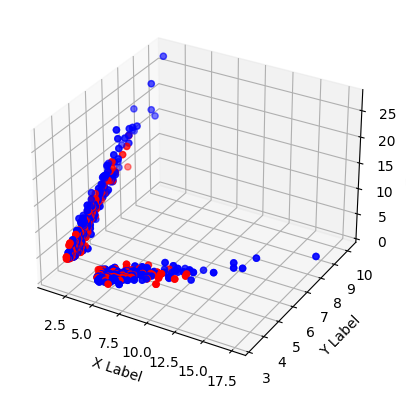

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Creazione del grafico
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Colori per i valori di y_train
colors = ['red' if y == 0 else 'blue' for y in y_train]

# Aggiunta dei dati al grafico
ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2], c=colors)

# Etichette degli assi
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Mostra il grafico
plt.show()

In [29]:
import plotly.graph_objs as go

# Colori per i valori di y_train
colors = ['red' if y == 0 else 'blue' for y in np.concatenate((y_train, y_test))]

# Creazione della traccia dello scatter 3D
trace = go.Scatter3d(
    x=np.concatenate((X_train[:,0], X_test[:, 0])),
    y=np.concatenate((X_train[:,1], X_test[:, 1])),
    z=np.concatenate((X_train[:,2], X_test[:, 2])),
    mode='markers',
    marker=dict(
        size=5,
        color=colors,
        opacity=0.8,
        colorscale='Viridis'
    )
)

# Layout del grafico
layout = go.Layout(
    scene=dict(
        xaxis_title='H Label',
        yaxis_title='D Label',
        zaxis_title='A Label',
        xaxis=dict(title='H'),
        yaxis=dict(title='D'),
        zaxis=dict(title='A')
    ),
    width=1500,  # Imposta la larghezza della figura a 800 pixel
    height=800  # Imposta l'altezza della figura a 800 pixel
)

# Creazione della figura
fig = go.Figure(data=[trace], layout=layout)

# Visualizzazione della figura
fig.show()

### KNN

              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90        80
         1.0       0.94      0.97      0.95       164

    accuracy                           0.94       244
   macro avg       0.94      0.92      0.93       244
weighted avg       0.94      0.94      0.94       244



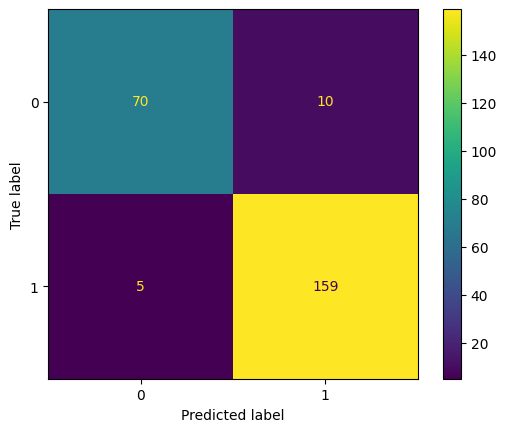

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# Create Decision Tree classifer object
clf = KNeighborsClassifier(algorithm='auto', n_jobs=-1, n_neighbors=30, weights='distance')

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Salvo il modello

In [33]:
import pickle as pk

# Create Decision Tree classifer object
clf = KNeighborsClassifier(algorithm='auto', n_jobs=-1, n_neighbors=30, weights='distance')

# Train Decision Tree Classifer
clf = clf.fit(X, y)

pk.dump(clf, open("knn-model.sav", 'wb'))

## Support vector machine

In [41]:
from sklearn.svm import SVC

svm = SVC(C=0.0001, degree=1, kernel='poly')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79       288
           1       0.00      0.00      0.00       151

    accuracy                           0.66       439
   macro avg       0.33      0.50      0.40       439
weighted avg       0.43      0.66      0.52       439



/home/lorenzo/miniconda3/envs/datas/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lorenzo/miniconda3/envs/datas/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lorenzo/miniconda3/envs/datas/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [44]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.0001, 0.001, 0.01, 1, 10, 50], 
              'gamma': ['scale', 'auto'],
              'kernel': ['rbf', 'linear', 'poly'],
              'degree': [i for i in range(1, 4)]


}

# definizione del metodo di ricerca migliore combinazione di iper-parametri
grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv=2, n_jobs=-1, verbose=True, scoring='precision')

grid_search.fit(X_test, y_test)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


/home/lorenzo/miniconda3/envs/datas/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lorenzo/miniconda3/envs/datas/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lorenzo/miniconda3/envs/datas/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lorenzo/miniconda3/envs/datas/lib/python3.10/s

GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 1, 10, 50],
                         'degree': [1, 2, 3], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='precision', verbose=True)

In [45]:
# stampa dei migliori parametri e punteggi ottenuti
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Best parameters:  {'C': 0.001, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.88
Test set score: 0.84


In [24]:
import pickle as pk

svm = SVC(C=0.0004, degree=1, kernel='poly')
svm.fit(X, y)

pk.dump(svm, open("svm-model.sav", 'wb'))